# Optotagged waveforms
pull waveforms form kilosort files and compare between different optotagged units


In [1]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import nems.db as nd
import nems_lbhb.baphy_io as io
# from src.root_path import config_path

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-10-29 180346.log


#### identify phototagged cells


In [2]:
# plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])
# plt.style.use(['default', config_path / 'notebook.mplstyle'])

# config = ConfigParser()
# config.read_file(open(config_path / 'settings.ini'))

In [3]:
runclass = 'NAT'
runclass = '%'
sql = "SELECT sCellFile.*,gSingleCell.siteid,gSingleCell.phototag FROM gSingleCell " +\
      "INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid " +\
      "INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid " +\
      f"WHERE gRunClass.name like '{runclass}' AND not(isnull(phototag))"
d = nd.pd_query(sql)
d['parmfile'] = d['stimpath'] + d['stimfile']
d['animal'] = d['stimpath'].apply(lambda x: x.split('/')[-3])

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


#### select sites and parameter files, and parses optotagging values

In [4]:
ff_tag = d.phototag.isin(['a', 's'])
tag_df = d.loc[ff_tag, ['cellid', 'phototag', 'animal']].drop_duplicates()

#### load recordings, gets tuning curves, organizes in big array

In [5]:
def get_waveform_metrics(mwf):
    """
    powered by Charlie: Calculates spike width in ms (sw), peak-through ratio (ptr), full width half max in ms (fwhm), end slope (es)
    time to base line in ms (bs) and trough in index, all over a smoothed and normazlized waveform (wf)
    :param mwf: 1d array of waveform,
    :return: sw, prt, fwhm, bs, trough, wf
    """
    fit2 = interpolate.UnivariateSpline(np.arange(len(mwf)), mwf)
    mwf = fit2(np.linspace(0, len(mwf), 10000))
    mwf /= abs(mwf.min())
    wf = mwf

    if mwf[np.argmax(np.abs(mwf))] > 0:
        sw = ptr = fwhm = es = bs = trough = np.nan

    else:
        fs = 10000 / (82 / 30000)
        valley = np.argmin(mwf)
        peak = np.argmax(mwf[valley:]) + valley
        trough = valley

        # force 0 to be the mean of the positive waveform preceding the valley
        mi = np.argmax(mwf[:valley])
        baseline = np.mean(mwf[:mi])
        mwf -= baseline

        sw = (peak - valley) / fs * 1000  # ms

        # get fwhm (of valley)
        left = np.argmin(np.abs(mwf[:valley] - (mwf[valley] / 2)))
        right = np.argmin(np.abs(mwf[valley:] - (mwf[valley] / 2))) + valley
        fwhm = (right - left) / fs * 1000

        if mwf[peak] <= 0:
            ptr = 0
        else:
            ptr = abs(mwf[peak]) / abs(mwf[valley])

        #0.5 ms ~ 1800 bins
        #es.append((((mwf[valley + 850] - mwf[valley + 650])*fs) / (200 * fs)))
        #es.append((mwf[valley + 950] - mwf[valley + 900]) / 50)
        #es.append((mwf[valley + 1800] - mwf[valley + 1750]) / 50)
        #es.append((mwf[valley + 780] - mwf[valley + 750]))
        #es.append((mwf[valley + 2200] - mwf[valley + 900]))
        es = (mwf[valley + 550] - mwf[valley + 350])
        # save time waveform returns to baseline
        bs = np.argmin(np.abs(mwf[peak:])) / fs * 1000

    return sw, ptr, fwhm, es, bs, trough, wf


eg_waveform = io.get_mean_spike_waveform('TNC017a-09-1', 'Teonancatl', usespkfile=True)

sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(eg_waveform)
print(sw, ptr, fwhm, es, bs, trough)

0.6811466666666667 0.11569482132688969 0.28454 0.13474185318130805 0.5286266666666667 4939


In [6]:
print('loading all waveforms into dataframe ...')

# df_file = pl.Path(config['paths']['analysis_cache']) / '211028_waveform_summary_df'
# recache = True
# 
# if df_file.exists() and recache == False:
#     print(f'DF file found\nloading from {df_file}')
#     DF = jl.load(df_file)
# else:
DF = pd.DataFrame()
for _, row in tag_df.iterrows():
    mean_waveform = io.get_mean_spike_waveform(row.cellid, row.animal, usespkfile=True)

    if mean_waveform.size == 0:
        print(f'cant get {row.cellid} waveform')
        continue

    sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(mean_waveform)

    df = pd.DataFrame()
    df['cellid'] = (row.cellid,)
    df['sw'] = (sw,)
    df['ptr'] = (ptr,)
    df['fwhm'] = (fwhm,)
    df['es'] = (es,)
    df['bs'] = (bs,)
    df['trough'] = (trough,)
    df['waveform'] = (mean_waveform.tolist(),)
    df['waveform_norm'] = (wf.tolist(),)
    DF = DF.append(df, ignore_index=True)
    # jl.dump(DF, df_file)

print('done')

loading all waveforms into dataframe ...


/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC015a-11-2 0 TNC015a12_p_NON.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC015a-20-2 0 TNC015a12_p_NON.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC015a-23-2 0 TNC015a12_p_NON.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC015a-30-3 0 TNC015a12_p_NON.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC017a-18-2 0 TNC017a12_p_NON.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC017a-18-2 1 TNC017a13_p_TOR.spk.mat
[nems_lbhb.baphy_io INFO] Can't get Mean Waveform for TNC017a-18-3 0 TNC017a12_p_NON.spk.mat
[nems_lbhb

done


In [7]:
d=nd.get_cell_files('TNC018a-03-5')
d

,id,cellid,masterid,rawid,celldataid,runclassid,path,resplen,repcount,respfile,...,channum,sortidx,model,stimsnr,area,goodtrials,respZ,respSNR,name,isolation
0,151176,TNC018a-03-5,45727,144219,0,1,/auto/data/daq/Teonancatl/TNC018/sorted/,5990400,2,TNC018a15_p_TOR.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,TOR,32.406
1,151232,TNC018a-03-5,45727,144220,0,65,/auto/data/daq/Teonancatl/TNC018/sorted/,4219904,60,TNC018a16_p_BNB.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,BNB,32.406
2,151288,TNC018a-03-5,45727,144221,0,51,/auto/data/daq/Teonancatl/TNC018/sorted/,6103040,2,TNC018a17_p_NON.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,NON,32.406
3,151344,TNC018a-03-5,45727,144222,0,112,/auto/data/daq/Teonancatl/TNC018/sorted/,31553536,1,TNC018a18_p_NAT.spk.mat,...,3,1,0,100,A1,,0.0,0.0,NAT,32.406
4,151400,TNC018a-03-5,45727,144224,0,112,/auto/data/daq/Teonancatl/TNC018/sorted/,32736256,1,TNC018a19_p_NAT.spk.mat,...,3,1,0,100,A1,,0.0,0.0,NAT,32.406


In [8]:
DF.loc[DF.cellid=='TNC018a-12-4']

,cellid,sw,ptr,fwhm,es,bs,trough,waveform,waveform_norm
356,TNC018a-12-4,0.707113,0.136478,0.287273,0.164066,0.555687,4947.0,"(35.35318332739771, 39.38207881679872, 42.3302...","(0.010058323891188645, 0.010115532231211977, 0..."


In [9]:
DF.shape, tag_df.shape

((420, 9), (420, 3))

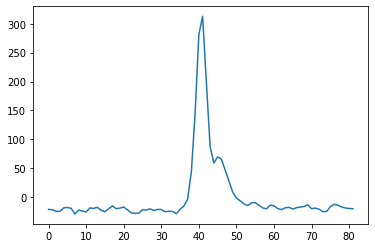

In [10]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='1:1')
bad=merge.loc[np.isnan(merge.sw)]
plt.figure()
plt.plot(bad.iloc[4]['waveform'])

In [32]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='1:1').dropna()
merge.shape

(504, 11)

# Waveform analysis
## activated neurons

In [36]:
csw = merge['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = merge['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = merge['es'].values
wf = merge['waveform_norm'].values
trough = merge['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
merge['labels'] = gmm.predict(X)
merge['wshape'] = ""
test_width = merge.groupby('labels')['sw'].mean()
if test_width.loc[0]>test_width.loc[1]:
    merge.loc[merge['labels']==0,'wshape']='RS'
    merge.loc[merge['labels']==1,'wshape']='NS'
else:
    merge.loc[merge['labels']==0,'wshape']='NS'
    merge.loc[merge['labels']==1,'wshape']='RS'
   
merge.drop(columns=['waveform_norm']).to_csv('phototag_waveform_labels.csv')

In [38]:
test_width = merge.groupby('wshape')['sw'].mean()
test_width

wshape
NS    0.322640
RS    0.726854
Name: sw, dtype: float64

In [67]:
merge.groupby(['phototag','labels']).count()
merge.loc[merge.phototag=='a',['cellid','labels','wshape']]

,cellid,labels,wshape
17,TNC014a-45-5,0,NS
27,TNC017a-60-1,0,NS
56,TNC015a-58-1,1,RS
57,TNC015a-55-2,1,RS
58,TNC015a-51-1,0,NS
...,...,...,...
444,TNC018a-36-5,0,NS
448,TNC018a-48-4,0,NS
450,TNC020a-04-1,0,NS
452,TNC020a-10-1,0,NS


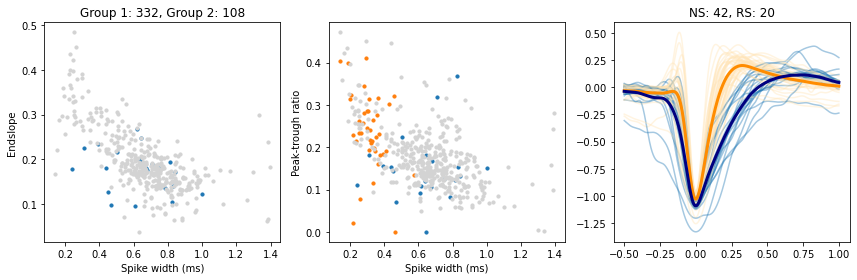

In [69]:
toplot = merge.loc[merge.phototag == 'a', ['cellid', 'sw', 'ptr', 'es', 'waveform_norm', 'trough']].dropna(axis=0)

csw = toplot['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = toplot['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = toplot['es'].values
wf = toplot['waveform_norm'].values
trough = toplot['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)


f, ax = plt.subplots(1, 3, figsize=(12, 4))

_i = (merge['phototag']=='s')
_i1 = (merge['labels'] == 1) & (merge['phototag']=='a')
_i0 = (merge['labels'] == 0) & (merge['phototag']=='a')
ax[0].scatter(merge.loc[_i1,'sw'], merge.loc[_i1,'es'], s=10)
ax[0].scatter(merge.loc[_i0,'sw'], merge.loc[_i0,'es'], s=10)
ax[0].scatter(merge.loc[_i,'sw'], merge.loc[_i,'es'], s=10, color='lightgray')
ax[0].set_xlabel('Spike width (ms)')
ax[0].set_ylabel('Endslope')
ax[0].set_title(f"Group 1: {sum(merge['labels'] == 1)}, Group 2: {sum(merge['labels'] == 0)}")

ax[1].scatter(merge.loc[_i1,'sw'], merge.loc[_i1,'ptr'], s=10)
ax[1].scatter(merge.loc[_i0,'sw'], merge.loc[_i0,'ptr'], s=10)
ax[1].scatter(merge.loc[_i,'sw'], merge.loc[_i,'ptr'], s=10, color='lightgray')
ax[1].set_xlabel('Spike width (ms)')
ax[1].set_ylabel('Peak-trough ratio')

centered = []
fs = 10000 / (82 / 30000)
for w, wave in enumerate(wf):
    wave = np.asarray(wave)
    t = int(trough[w])
    wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
    time = np.linspace(-.5, 1, wave.shape[0])

    if labels[w] == 0:
        color = 'moccasin'
    else:
        color = 'tab:blue'
    centered.append(wave)
    ax[2].plot(time, wave, color=color, alpha=0.4)

ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

# categorize as NS / RS -- force Narrow to be label==1
if csw[labels == 1].mean() < csw[labels == 0].mean():
    ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
else:
    ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

f.tight_layout()

plt.show()

KeyError: "None of [Index(['label'], dtype='object')] are in the [columns]"

## suppresed neurons

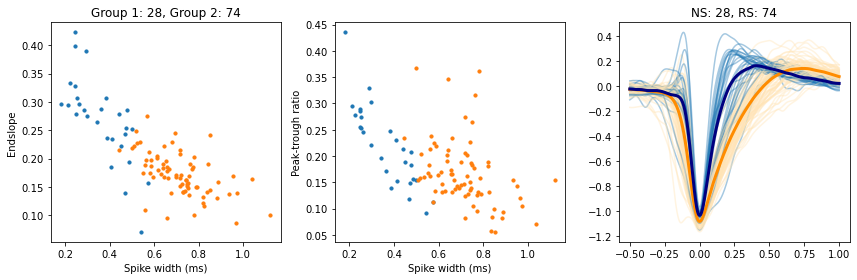

In [12]:
toplot = merge.loc[merge.phototag == 's', ['cellid', 'sw', 'ptr', 'es', 'waveform_norm', 'trough']].dropna(axis=0)

csw = toplot['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = toplot['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = toplot['es'].values
wf = toplot['waveform_norm'].values
trough = toplot['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
f, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(csw[labels == 1], ces[labels == 1], s=10)
ax[0].scatter(csw[labels == 0], ces[labels == 0], s=10)
ax[0].set_xlabel('Spike width (ms)')
ax[0].set_ylabel('Endslope')
ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

ax[1].scatter(csw[labels == 1], cptr[labels == 1], s=10)
ax[1].scatter(csw[labels == 0], cptr[labels == 0], s=10)
ax[1].set_xlabel('Spike width (ms)')
ax[1].set_ylabel('Peak-trough ratio')

centered = []
fs = 10000 / (82 / 30000)
for w, wave in enumerate(wf):
    wave = np.asarray(wave)
    t = int(trough[w])
    wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
    time = np.linspace(-.5, 1, wave.shape[0])

    if labels[w] == 0:
        color = 'moccasin'
    else:
        color = 'tab:blue'
    centered.append(wave)
    ax[2].plot(time, wave, color=color, alpha=0.4)

ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

# categorize as NS / RS -- force Narrow to be label==1
if csw[labels == 1].mean() < csw[labels == 0].mean():
    ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
else:
    ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

f.tight_layout()

plt.show()